In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import shutil

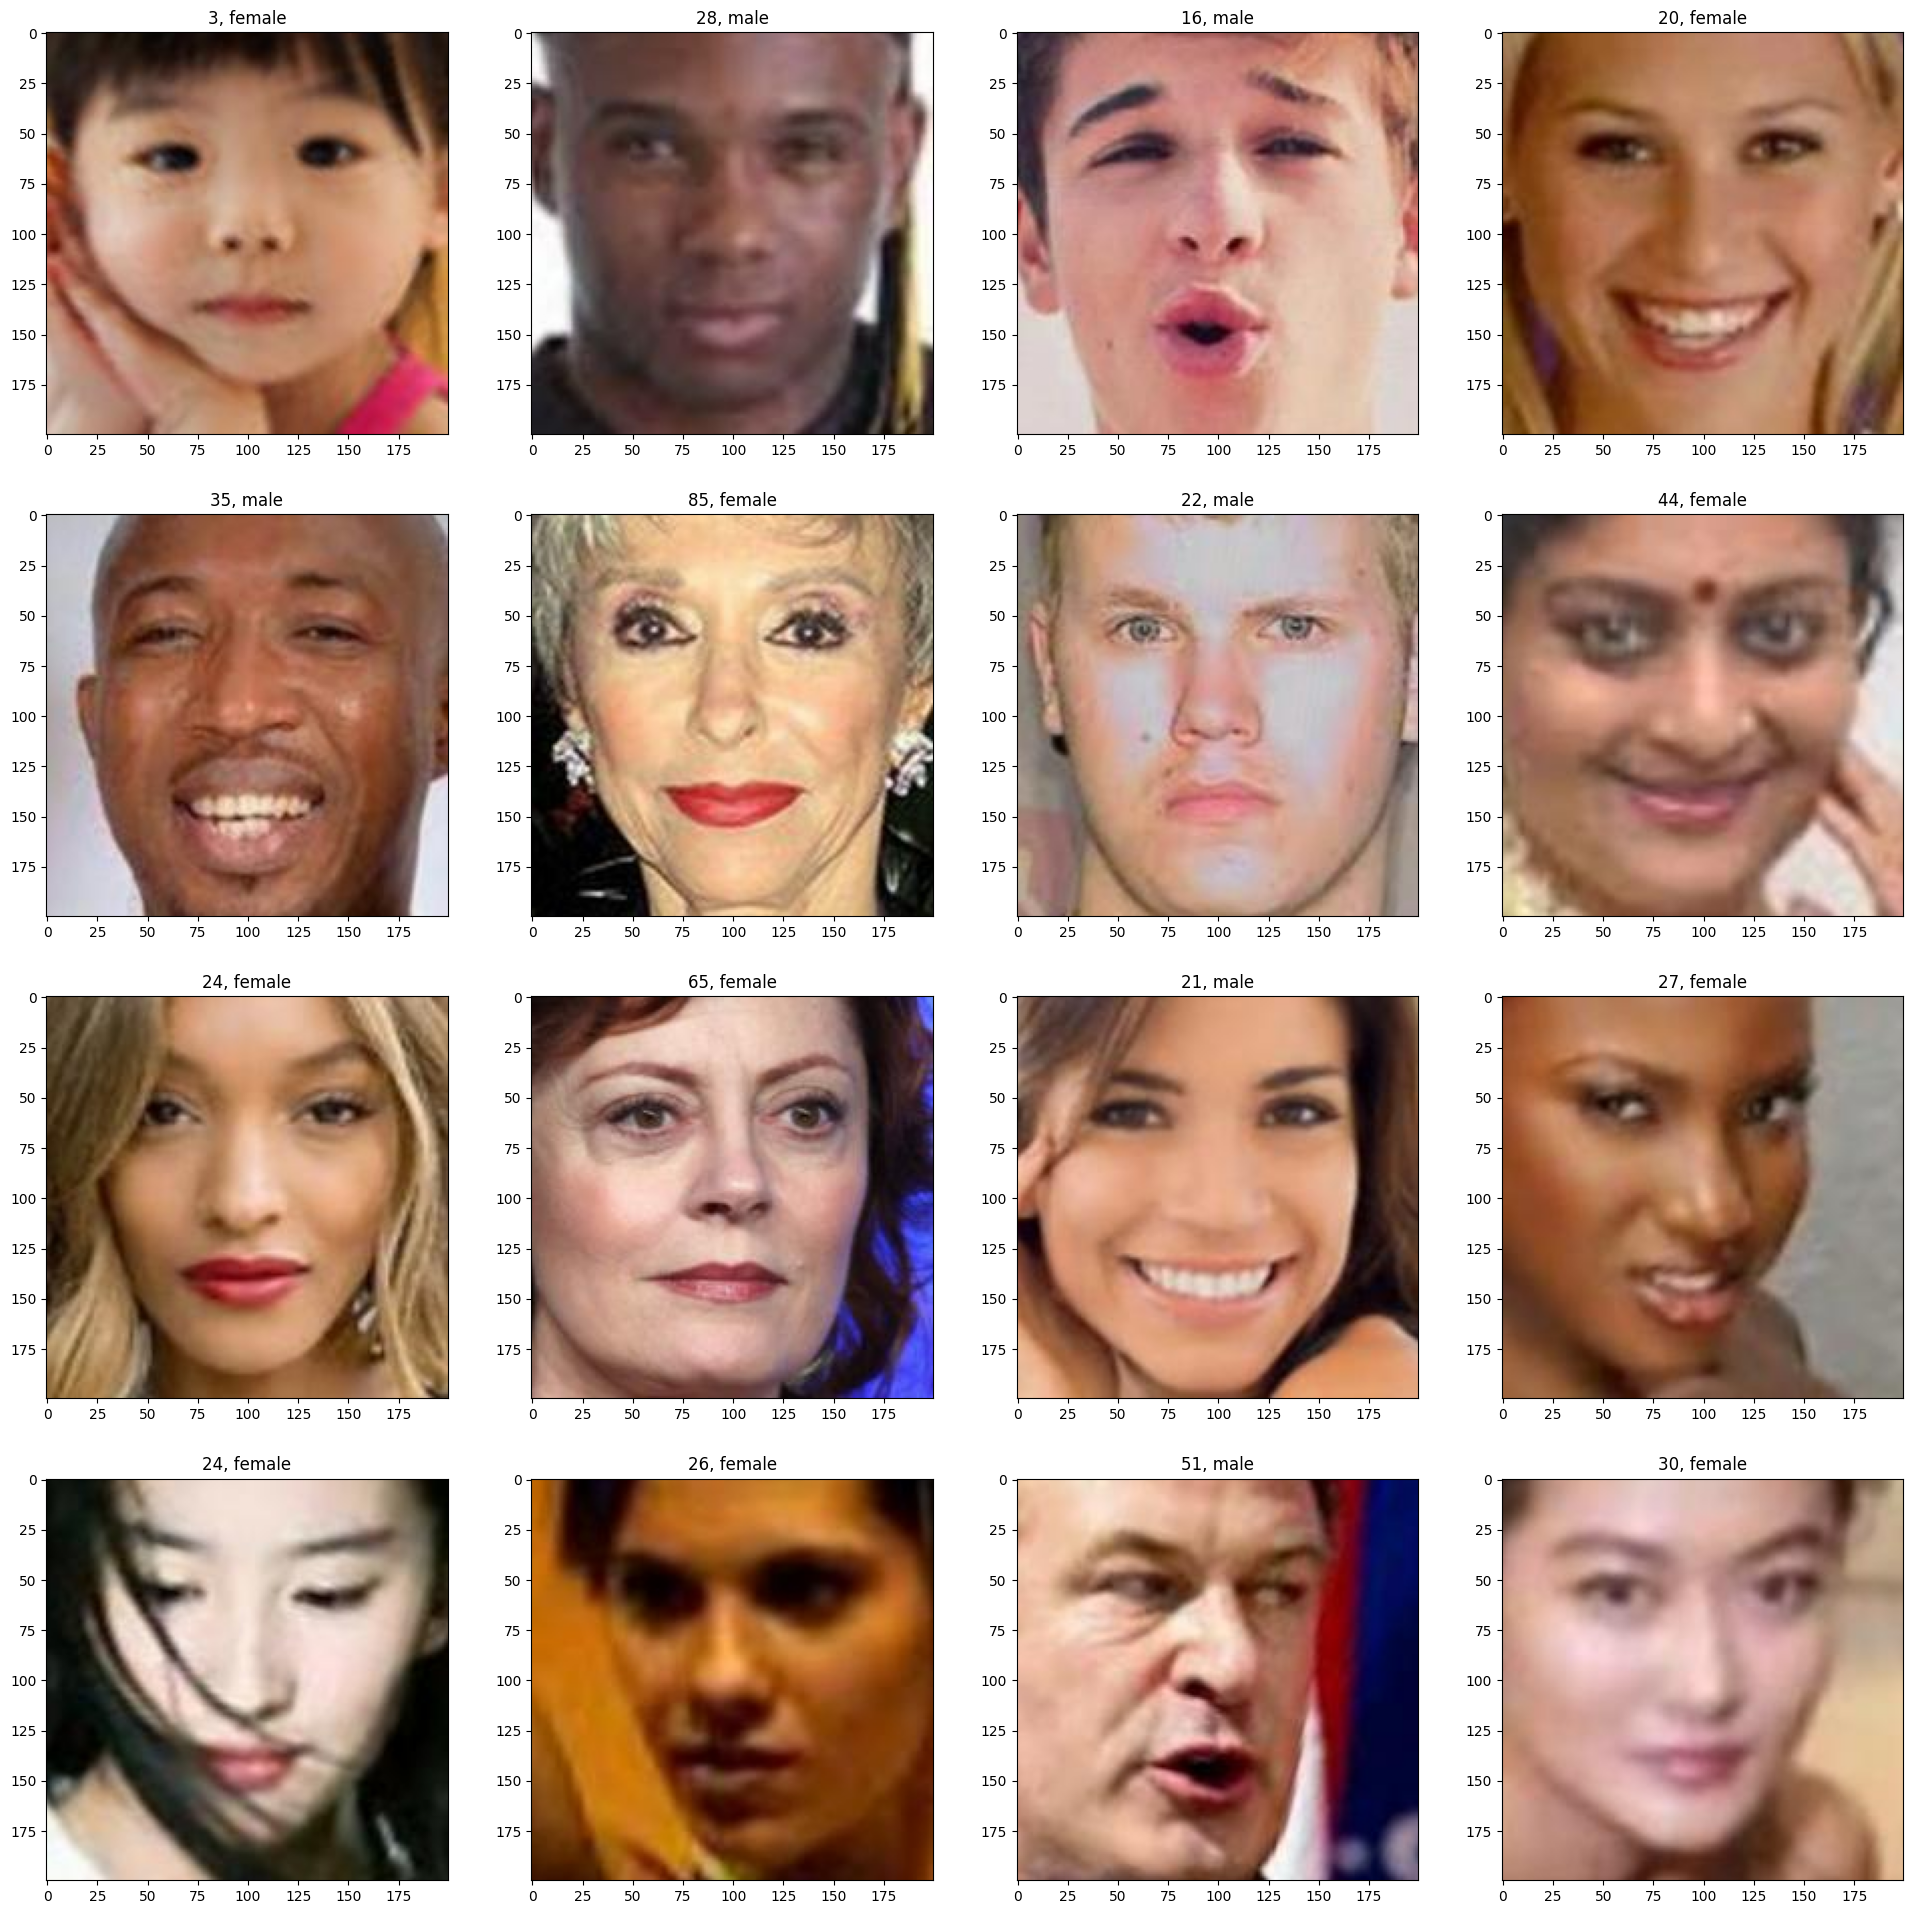

In [30]:
images = os.listdir("/kaggle/input/utkface-new/UTKFace")
offset = 100

plt.figure(figsize=(24, 24))

for i in range(4):
    for j in range(4):
        age, gender = images[offset + i * 4 + j].split('_')[:2]
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.title(f"{age}, {'male' if gender == '0' else 'female'}")
        plt.imshow(tf.image.resize(image.load_img("/kaggle/input/utkface-new/UTKFace/" + images[offset + i * 4 + j]), (200, 200)) / 255.)

# Making dataset

In [132]:
data = "/kaggle/input/utkface-new/UTKFace/"

In [199]:
df = pd.DataFrame({
    'file': os.listdir(data)
})

In [200]:
df.head()

file
0  26_0_2_20170104023102422.jpg.chip.jpg
1  22_1_1_20170112233644761.jpg.chip.jpg
2  21_1_3_20170105003215901.jpg.chip.jpg
3  28_0_0_20170117180555824.jpg.chip.jpg
4  17_1_4_20170103222931966.jpg.chip.jpg

In [201]:
df['age'] = df.file.str.split('_', n=1, expand=True).loc[:, 0]

In [202]:
df.head()

file age
0  26_0_2_20170104023102422.jpg.chip.jpg  26
1  22_1_1_20170112233644761.jpg.chip.jpg  22
2  21_1_3_20170105003215901.jpg.chip.jpg  21
3  28_0_0_20170117180555824.jpg.chip.jpg  28
4  17_1_4_20170103222931966.jpg.chip.jpg  17

In [203]:
def process_age(x):
    groups = [0, 30, 60]
    
    for i in range(len(groups) - 1):
        if groups[i] <= int(x) < groups[i + 1]:
            return i
    else:
        return len(groups) - 1
    
df['age_group'] = df.age.apply(process_age)

In [204]:
df.head()

file age  age_group
0  26_0_2_20170104023102422.jpg.chip.jpg  26          0
1  22_1_1_20170112233644761.jpg.chip.jpg  22          0
2  21_1_3_20170105003215901.jpg.chip.jpg  21          0
3  28_0_0_20170117180555824.jpg.chip.jpg  28          0
4  17_1_4_20170103222931966.jpg.chip.jpg  17          0

<Axes: xlabel='age_group', ylabel='count'>

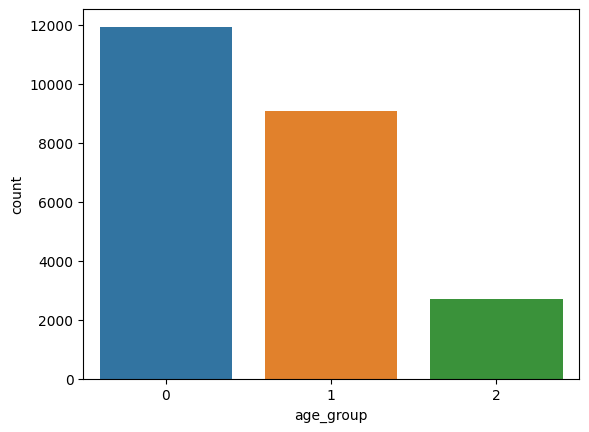

In [205]:
sns.countplot(x=df.age_group)

In [140]:
X = df.file.to_numpy().astype('object')
Y = df.age_group.to_numpy()

In [141]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y)

In [142]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((17781,), (5927,), (17781,), (5927,))

In [143]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest))

In [144]:
IMAGE_SIZE = 200
BATCH_SIZE = 16

In [145]:
def load_images(x, y):
    x = tf.io.read_file(data + x)
    x = tf.io.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)) / 255.
    return x, y

In [146]:
train_ds = train_ds.map(load_images)
val_ds = val_ds.map(load_images)

In [147]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(200, 200, 3)
()
(200, 200, 3)
()


In [148]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)
val_ds = val_ds.shuffle(1000).batch(BATCH_SIZE)

In [149]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0, 1]),
    tf.keras.layers.RandomContrast(0.2),
])

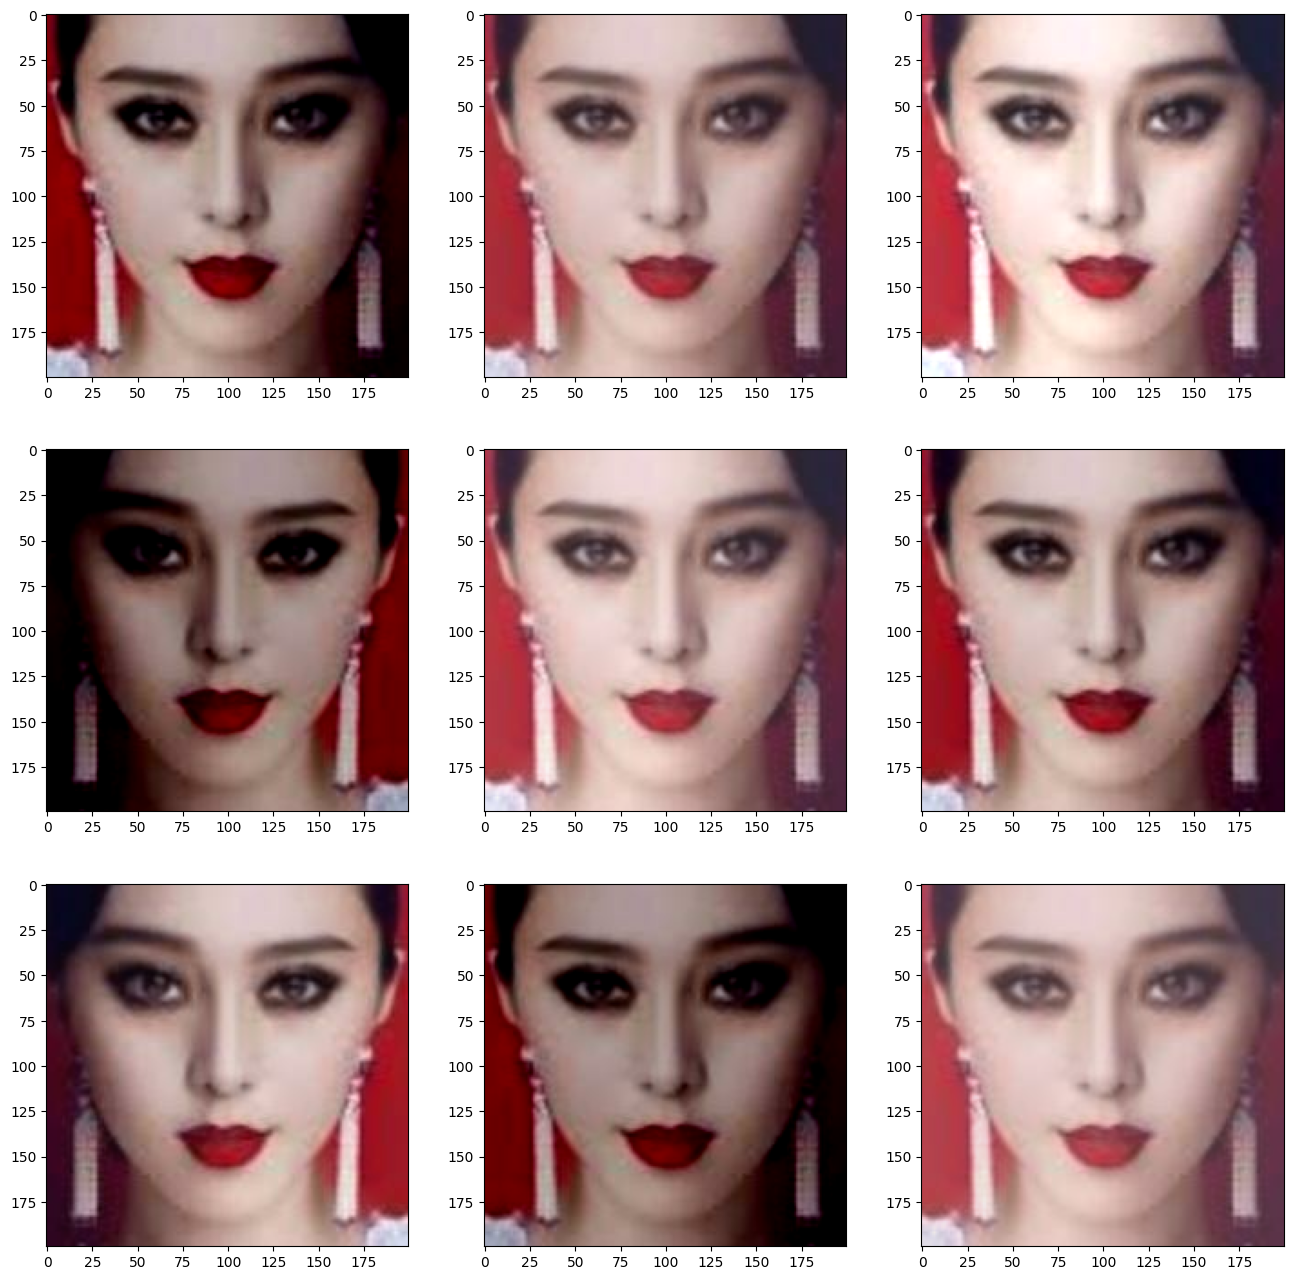

In [150]:
plt.figure(figsize=(16, 16))

for x, y in train_ds:
    for i in range(1, 10):
        plt.subplot(3, 3, i)
        plt.imshow(data_augmentation(x)[0])
    break

plt.show()

## Making a model

In [218]:
class_weights = dict(df.age_group.value_counts()[0] / df.age_group.value_counts())

In [151]:
def plot_graph(history):
    plt.figure(figsize=(12, 6))
    epoch_arr = [i for i in range(history.params['epochs'])]
    
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(epoch_arr, history.history['loss'])
    plt.plot(epoch_arr, history.history['val_loss'])
    plt.legend(["Train", "Validation"])
    
    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(epoch_arr, history.history['accuracy'])
    plt.plot(epoch_arr, history.history['val_accuracy'])
    plt.legend(["Train", "Validation"])
    
    plt.show()

## Delete variables

In [220]:
del xtrain, xtest, ytrain, ytest, df

In [241]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [242]:
# to set the output shapes
model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


array([[0.33875903, 0.287752  , 0.37348896],
       [0.33845112, 0.2607188 , 0.40083012],
       [0.3223643 , 0.2392986 , 0.43833712],
       [0.33742142, 0.30539992, 0.3571786 ],
       [0.32246083, 0.24634358, 0.43119556],
       [0.34820735, 0.24449745, 0.4072952 ],
       [0.34948596, 0.28226787, 0.36824617],
       [0.33908764, 0.24316792, 0.4177444 ],
       [0.34699264, 0.30152556, 0.35148183],
       [0.34335008, 0.2699662 , 0.38668367],
       [0.34064817, 0.23367365, 0.42567816],
       [0.34387043, 0.24432556, 0.41180396],
       [0.31621927, 0.31062785, 0.37315288],
       [0.3373434 , 0.2764295 , 0.38622707],
       [0.3273968 , 0.28477582, 0.38782743],
       [0.32888946, 0.2605059 , 0.41060466]], dtype=float32)

In [243]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (16, 200, 200, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (16, 198, 198, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (16, 99, 99, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (16, 99, 99, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (16, 97, 97, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (16, 48, 48, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (16, 48, 48, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (16, 46, 46, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (16, 23, 23, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (16, 23, 23, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (16, 33856)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (16, 128)              │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (16, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (16, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,358,115 (16.62 MB)

 Trainable params: 4,357,891 (16.62 MB)

 Non-trainable params: 224 (896.00 B)

In [244]:
history = model.fit(train_ds, validation_data=val_ds, epochs=40, batch_size=BATCH_SIZE, class_weight=class_weights)

Epoch 1/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5422 - loss: 1.3875 - val_accuracy: 0.6722 - val_loss: 0.7387
Epoch 9/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5670 - loss: 1.3395 - val_accuracy: 0.6653 - val_loss: 0.7134
Epoch 10/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5640 - loss: 1.3209 - val_accuracy: 0.7010 - val_loss: 0.6917
Epoch 11/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5829 - loss: 1.2820 - val_accuracy: 0.6804 - val_loss: 0.6972
Epoch 12/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5837 - loss: 1.2998 - val_accuracy: 0.6867 - val_loss: 0.6931
Epoch 13/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5977 - loss: 1.2601 - val_accuracy: 0.6914 - val_loss: 0.7279
Epoch 14/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5904 - loss: 1.2415 - val_accuracy: 0.6710 - val_loss: 0.7427
Epoch 15/40
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.

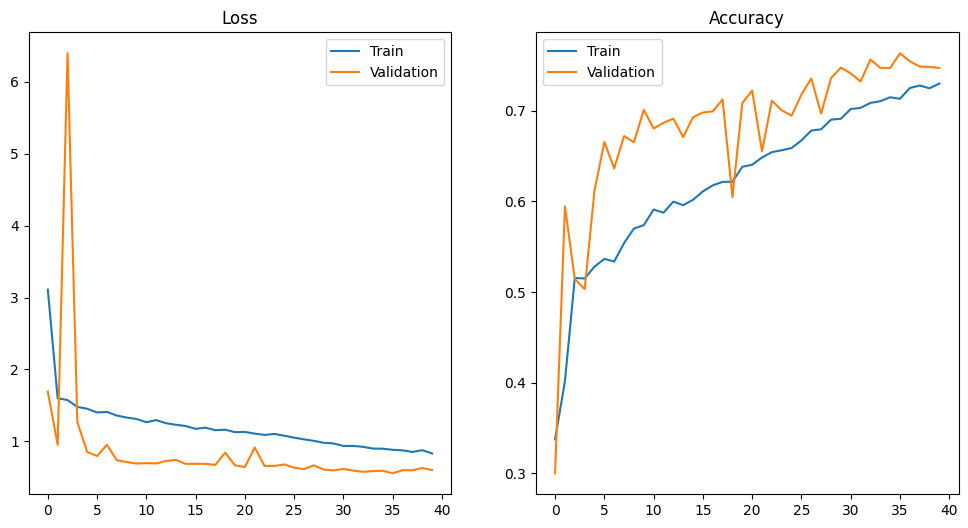

In [245]:
plot_graph(history)